# Upload Tasmanian Post Office Directory images to Amazon s3 for IIIF

We're going to make the page images from the Tasmanian Post Office Directories available via IIIF so they can be easily embedded within the new search interface. To do this we'll convert into pyramidal TIFFs using [pyvips](https://pypi.org/project/pyvips/) and then upload them to an Amazon s3 bucket. We'll then create a [Serverless IIIF](https://github.com/samvera-labs/serverless-iiif) app and point it at the bucket.

You'll need to have set up Amazon authentication on your computer. See the [boto3 documentation](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#configuration) for details.

You'll also need to create an s3 bucket with the correct permissions. The easiest way to do that is to use Simon Willison's [s3-credentials](https://s3-credentials.readthedocs.io/en/stable/) tool. Once that's installed you can create a bucket with public access permissions like this (change the region as necessary):

``` shell
s3-credentials create tasmania-directories --public --create-bucket --bucket-region "ap-southeast-2"
```

You'll also want to enable CORS.

``` shell
s3-credentials set-cors-policy tasmania-directories
```

In [2]:
from pathlib import Path

import boto3
import pyvips
from IPython.display import Image
from natsort import natsorted, ns

This code just loops through all the volumes of the Post Office Directories, then through all the page images for each volume. Each image is converted to a pyramidal TIFF then uploaded to the s3 bucket.

In [ ]:
# Initialise s3 client
s3 = boto3.client("s3")

# Loop through volumes in the 'tasmania' directory
# Each volume has its own directory containing text and images
vols = natsorted(
    [d for d in Path("tasmania").glob("AUTAS*") if d.is_dir()], alg=ns.PATH
)
for vol in vols:
    print(vol.name)
    # Create directory for TIFFs
    output_dir = Path(vol, "tiffs")
    output_dir.mkdir(exist_ok=True)
    # Loop through all the images in this volume
    vol_images = natsorted(Path(vol, "images").glob("*.jpg"), alg=ns.PATH)
    for img in vol_images:
        pid = img.stem
        # Convert image to a pyramidal TIFF
        image = pyvips.Image.new_from_file(img)
        image.tiffsave(
            Path(output_dir, f"{pid}.tif"),
            pyramid=True,
            tile=True,
            compression="jpeg",
            Q=90,
            tile_width=256,
            tile_height=256,
        )
        # Upload TIFF to s3, note the 'ContentType' setting so images will have appropriate headers
        s3.meta.client.upload_file(
            str(Path(output_dir, f"{pid}.tif")),
            "tasmania-directories",
            f"{pid}.tif",
            ExtraArgs={"ContentType": "image/tiff"},
        )

Once the images have been uploaded you can set up the [Serverless IIIF](https://github.com/samvera-labs/serverless-iiif) app. The latest version is pretty simple to get going. Just select the 'Standalone (Lambda-Only) Version' and add your bucket name. Of course, you'll need to have an Amazon account. Once the app is ready, you'll need to find the IIIF API endpoint. This is a bit tricky, but from the app page, click on 'Deployments', then 'Cloud Formation Stack'. Then from the cloud formation page, click on 'Outputs'. The IIIF API is listed as 'Endpoint'. For example, the endpoint for the Tasmanian Post Office Directory images is: `https://m6mq23u5ipveatowihutcbnph40eadkk.lambda-url.ap-southeast-2.on.aws/iiif/2/`.

The IIIF identifier for an image is its filename in the s3 bucket, minus the file extension. So the id of the image with the filename `AUTAS001126438076P1890-91PDF-127.tif` is just `AUTAS001126438076P1890-91PDF-127`. To access information about the image from the new IIIF server, you just add the id to the endpoint and add `info.json`. For example:

https://m6mq23u5ipveatowihutcbnph40eadkk.lambda-url.ap-southeast-2.on.aws/iiif/2/AUTAS001126438076P1890-91PDF-127/info.json

To access the image you just make an [IIIF image request](https://iiif.io/api/image/2.1/). Let's display a 250px wide thumbnail of the page above.

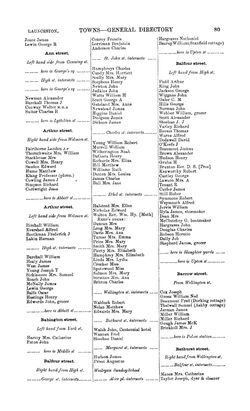

In [17]:
Image(
    "https://m6mq23u5ipveatowihutcbnph40eadkk.lambda-url.ap-southeast-2.on.aws/iiif/2/AUTAS001126438076P1890-91PDF-127/full/250,/0/default.jpg"
)

----
Created by [Tim Sherratt](https://timsherratt.org/) for the [GLAM Workbench](https://glam-workbench.net/) as part of the [Everyday Heritage](https://everydayheritage.au/) project.